#**Detecting Spam Emails Using Tensorflow in Python**

#####**- `Bujji Saikam`**

Spam messages refer to unsolicited or unwanted messages/emails that are sent in bulk to users. In most messaging/emailing services, messages are detected as spam automatically so that these messages do not unnecessarily flood the users’ inboxes. These messages are usually promotional and peculiar in nature. Thus, it is possible for us to build ML/DL models that can detect Spam messages.

we’ll build a TensorFlow-based Spam detector; in simpler terms, we will have to classify the texts as **`Spam`** or **`Ham`**. This implies that Spam detection is a case of a **`Text Classification`** problem. So, we’ll be performing EDA on our dataset and building a text classification model.

##**Importing Libraries**

**Python** libraries make it very easy for us to handle the data and perform typical and complex tasks with a single line of code.

- **`Pandas`**
– This library helps to load the data frame in a 2D array format and has multiple functions to perform analysis tasks in one go.
- **`Numpy`**
– Numpy arrays are very fast and can perform large computations in a very short time.
- **`Matplotlib/Seaborn/Wordcloud`**
– This library is used to draw visualizations.
- **`NLTK`** – Natural Language Tool Kit provides various functions to process the raw textual data.

In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#**Loading Dataset**

Now let’s load the dataset into a pandas data frame and look at the first five rows of the dataset.

In [2]:
# Try loading the CSV file with a different encoding
data = pd.read_csv('/content/sample_data/emails.csv',encoding='utf-8')

# Display the first 5 rows of the dataset
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


To check how many such tweets data we have let’s print the shape of the data frame.

In [3]:
data.shape

(5728, 2)

For a better understanding, we’ll plot these counts:

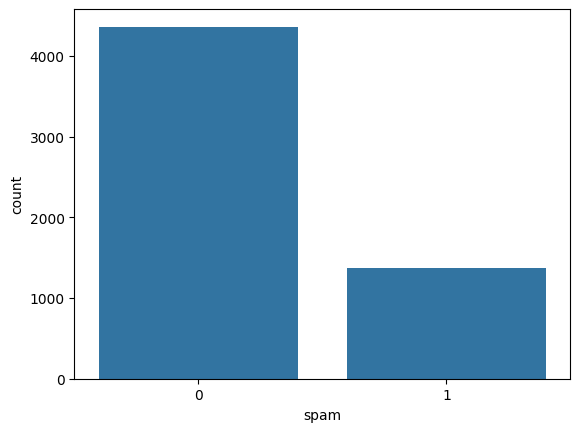

In [4]:
sns.countplot(x='spam', data=data)
plt.show()

We can clearly see that number of samples of Ham is much more than that of Spam which implies that the dataset we are using is imbalanced.

In [5]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
                         random_state=42)

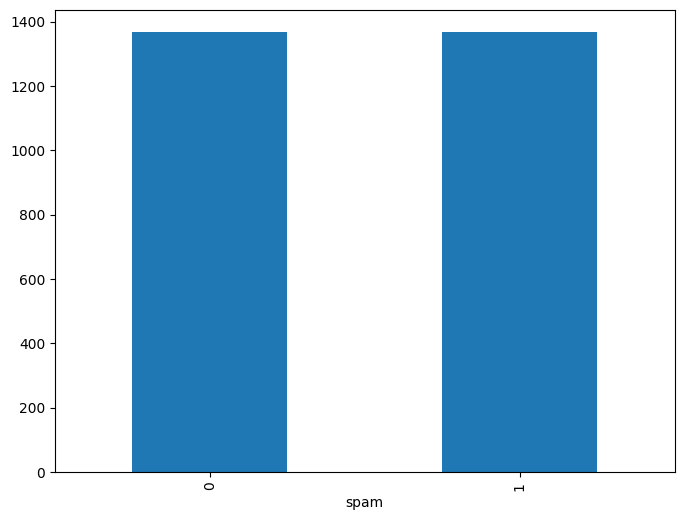

In [6]:
# Use pd.concat() instead of append()
balanced_data = pd.concat([ham_msg, spam_msg], ignore_index=True)

# Reset index if needed
balanced_data = balanced_data.reset_index(drop=True)

# Plotting the counts of the down-sampled dataset
plt.figure(figsize=(8, 6))
balanced_data['spam'].value_counts().plot(kind='bar')
plt.show()

#**Text Preprocessing**

Textual data is highly unstructured and need attention in many aspects:

- **`Stopwords`** Removal
- **`Punctuations`** Removal
- **`Stemming`** or **`Lemmatization`**

Although removing data means loss of information we need to do this to make the data perfect to feed into a machine learning model.

In [7]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [8]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


The below function is a helper function that will help us to remove the stop words.

In [9]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


A word cloud is a text visualization tool that help’s us to get insights into the most frequent words present in the corpus of the data.

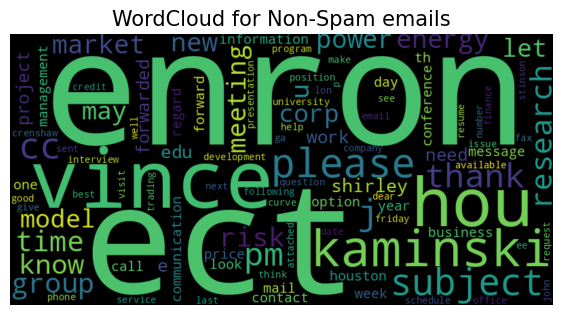

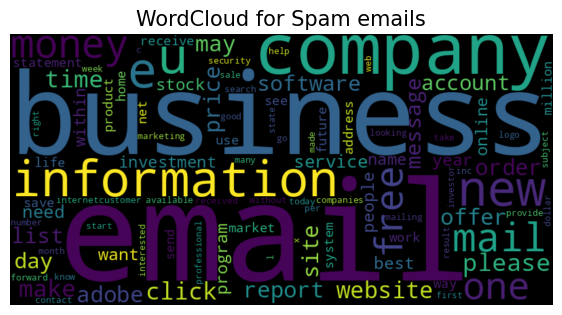

In [10]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

#**Word2Vec Conversion**
We cannot feed words to a machine learning model because they work on numbers only. So, first, we will convert our words to vectors with the token IDs to the corresponding words and after padding them our textual data will arrive to a stage where we can feed it to a model.

In [11]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42)

We have fitted the tokenizer on our training data we will use it to convert the training and validation data both to vectors.

In [12]:

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

#**Model Development and Evaluation**


We will implement a Sequential model which will contain the following parts:

- Three **`Embedding`** Layers to learn featured vector representations of the input vectors.

- An **`LSTM`**
layer to identify useful patterns in the sequence.

- Then we will have one fully connected layer.
- The final layer is the output layer which outputs probabilities for the two classes.

In [13]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

While compiling a model we provide these three essential parameters:

- **`optimizer`**
– This is the method that helps to optimize the cost function by using gradient descent.
- **`loss`**
– The loss function by which we monitor whether the model is improving with training or not.
- **`metrics`**
– This helps to evaluate the model by predicting the training and the validation data.

In [14]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

#**Callback**


Callbacks are used to check whether the model is improving with each epoch or not. If not then what are the necessary steps to be taken like **`ReduceLROnPlateau`** decreases the learning rate further? Even then if model performance is not improving then training will be stopped by **`EarlyStopping`**. We can also define some custom callbacks to stop training in between if the desired results have been obtained early.

In [15]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

Let us now train the model:

In [ ]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.5784 - loss: 0.6789 - val_accuracy: 0.7628 - val_loss: 0.5223 - learning_rate: 0.0010
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9188 - loss: 0.2803 - val_accuracy: 0.9635 - val_loss: 0.1694 - learning_rate: 0.0010
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9808 - loss: 0.1015 - val_accuracy: 0.9544 - val_loss: 0.1777 - learning_rate: 0.0010
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9654 - loss: 0.1376 - val_accuracy: 0.9690 - val_loss: 0.1250 - learning_rate: 0.0010
Epoch 5/20
11/69 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9919 - loss: 0.0490

Now, let’s evaluate the model on the validation data.

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

Thus, the training accuracy turns out to be 97.44% which is quite satisfactory.

#**Model Evaluation Results**

Having trained our model, we can plot a graph depicting the variance of training and validation accuracies with the no. of epochs.

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

####**`- Thank You`**